In [1]:
%load_ext autoreload
%autoreload 2

from snippets.loader import *
from snippets.torch_loader import *
from model import SSD300, MultiBoxLoss
from load_data import *
from utils import *
from load_data import *

keep_difficult = True

n_classes = len(label_map)
workers = 4
batch_size = 4

### Load Data

In [2]:
from pathlib import Path
_2007_root = Path("/home/yyr/data/VOCdevkit/VOC2007")
_2012_root = Path("/home/yyr/data/VOCdevkit/VOC2012")
train_items = get_items(_2007_root, 'train') + get_items(_2012_root, 'train')
val_items   = get_items(_2007_root, 'val')
logger.info(f'\n{len(train_items)} training images\n{len(val_items)} validation images')

train_dataset = VOCDataset(train_items[:32], tfms=aug_trn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)

val_dataset = VOCDataset(val_items[:32], tfms=aug_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=val_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)

2020-04-30 23:59:42.979 | INFO     | __main__:<module>:6 - 
8218 training images
2510 validation images


In [3]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch):
    model.train()
    N = len(train_loader)
    for bx, (images, boxes, labels, _) in enumerate(train_loader):
        images = images.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        _regr, _clss = model(images)
        loss = criterion(_regr, _clss, boxes, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        report.record(pos=epoch+((1+bx)/N), loss=loss.item(), end='\r')
    del _regr, _clss, images, boxes, labels
    
def validate(val_loader, model, criterion, epoch):
    model.eval()
    N = len(val_loader)
    for bx, (images, boxes, labels, _) in enumerate(val_loader):
        if bx % 10 != 0: continue # validate every 10th batch
        images = images.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        with torch.no_grad():
            _regr, _clss = model(images)
            loss = criterion(_regr, _clss, boxes, labels)
        report.record(pos=epoch+((1+bx)/N), val_loss=loss.item(), end='\r')
    del _regr, _clss, images, boxes, labels

In [4]:
epochs = 150
model = SSD300(n_classes=n_classes)
# model = torch.load('ssd300.pth', map_location=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
report = Report(n_epochs=epochs)

for epoch in range(epochs):
    train_one_epoch(train_loader, model, criterion, optimizer, epoch)
    validate(val_loader, model, criterion, epoch)
    if epoch%10 == 1: report.report_avgs(epoch+1)
    torch.save(model, 'ssd300.tmp.pth')


Loaded base model.



/home/yyr/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


EPOCH: 1.000	loss: 19.155	val_loss: 14.039	(2.21s - 1102.12s remaining)
EPOCH: 11.000	loss: 7.773	val_loss: 7.865	(25.56s - 1136.39s remaining)
EPOCH: 21.000	loss: 3.853	val_loss: 9.184	(48.86s - 1114.59s remaining)
EPOCH: 31.000	loss: 2.298	val_loss: 12.955	(72.28s - 1093.47s remaining)
EPOCH: 41.000	loss: 1.077	val_loss: 25.132	(94.74s - 1060.66s remaining)
EPOCH: 51.000	loss: 0.807	val_loss: 12.388	(117.52s - 1034.60s remaining)
EPOCH: 61.000	loss: 0.683	val_loss: 19.071	(139.98s - 1007.39s remaining)
EPOCH: 71.000	loss: 0.524	val_loss: 16.265	(162.32s - 980.78s remaining)
EPOCH: 81.000	loss: 0.484	val_loss: 12.463	(184.66s - 955.22s remaining)
EPOCH: 91.000	loss: 0.429	val_loss: 18.484	(207.02s - 930.44s remaining)
EPOCH: 101.000	loss: 0.428	val_loss: 15.996	(229.29s - 905.80s remaining)
EPOCH: 111.000	loss: 0.392	val_loss: 27.131	(251.64s - 881.86s remaining)
EPOCH: 121.000	loss: 0.327	val_loss: 22.072	(274.37s - 859.39s remaining)
EPOCH: 131.000	loss: 0.320	val_loss: 12.704	(297.

KeyboardInterrupt: 

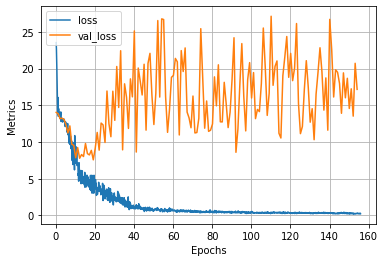

In [5]:
report.plot()